In [33]:
%pip install pandas_datareader
%pip install seaborn
%pip install pyupbit
%pip install statsmodels
%pip install pmdarima
%pip install itertools

import os
import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

import itertools
import pyupbit as pb


Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [34]:
df=pb.get_ohlcv("KRW-BTC", interval = "day", count = 1097, to = '20221201')
df

,open,high,low,close,volume,value
2020-03-08 09:00:00,10678000.0,10699000.0,9820000.0,9876000.0,5043.980892,5.184607e+10
2020-03-09 09:00:00,9883000.0,10064000.0,9356000.0,9726000.0,7692.575807,7.435140e+10
2020-03-10 09:00:00,9726000.0,9849000.0,9413000.0,9574000.0,4439.332333,4.277806e+10
2020-03-11 09:00:00,9574000.0,9637000.0,9163000.0,9510000.0,4110.017164,3.871819e+10
2020-03-12 09:00:00,9507000.0,9537000.0,5980000.0,6363000.0,29866.025098,2.350861e+11
...,...,...,...,...,...,...
2022-11-28 09:00:00,22661000.0,22690000.0,22217000.0,22339000.0,3579.090571,8.021448e+10
2022-11-29 09:00:00,22329000.0,22617000.0,22155000.0,22417000.0,2523.908210,5.664776e+10
2022-11-30 09:00:00,22417000.0,23293000.0,22415000.0,23192000.0,4690.575205,1.075721e+11
2022-12-01 09:00:00,23209000.0,23400000.0,22871000.0,23002000.0,3278.515197,7.576107e+10


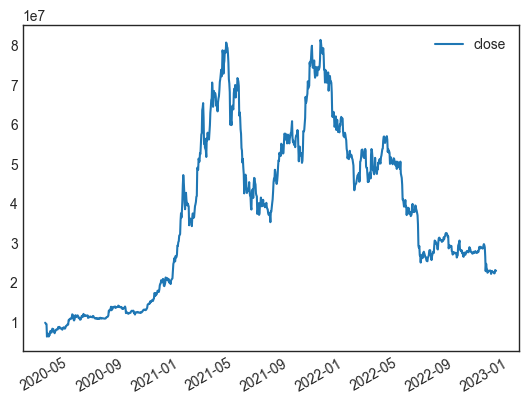

In [35]:
bitcoin_df= df.loc[:,['close']] #사용할 컬럼만 추출
bitcoin_df
fig = bitcoin_df.plot()

In [36]:
# Train Test = 8:2
from sklearn.model_selection import train_test_split
bitcoin_data_train, bitcoin_data_test = train_test_split(bitcoin_df, test_size=0.2, shuffle=False)
print(bitcoin_data_train)
print(bitcoin_data_test)

                          close
2020-03-08 09:00:00   9876000.0
2020-03-09 09:00:00   9726000.0
2020-03-10 09:00:00   9574000.0
2020-03-11 09:00:00   9510000.0
2020-03-12 09:00:00   6363000.0
...                         ...
2022-05-12 09:00:00  39243000.0
2022-05-13 09:00:00  39270000.0
2022-05-14 09:00:00  39967000.0
2022-05-15 09:00:00  40906000.0
2022-05-16 09:00:00  39256000.0

[800 rows x 1 columns]
                          close
2022-05-17 09:00:00  39259000.0
2022-05-18 09:00:00  37099000.0
2022-05-19 09:00:00  38780000.0
2022-05-20 09:00:00  37762000.0
2022-05-21 09:00:00  38037000.0
...                         ...
2022-11-28 09:00:00  22339000.0
2022-11-29 09:00:00  22417000.0
2022-11-30 09:00:00  23192000.0
2022-12-01 09:00:00  23002000.0
2022-12-02 09:00:00  23010000.0

[200 rows x 1 columns]


// 개략적인 모델 구축

train, test data를 먼저 스플릿/
추후 검정을 위해 분리/
타임 시리즈 데이터이기 때문에 shuffle은 하지 않는다./
뒷단에 20%가 예측에 활용될 수 있도록 구성

- test_size: 테스트 셋 구성의 비율을 나타냅니다. train_size의 옵션과 반대 관계에 있는 옵션 값이며, 주로 test_size를 지정해 줍니다. 0.2는 전체 데이터 셋의 20%를 test (validation) 셋으로 지정하겠다는 의미입니다. default 값은 0.25 입니다.
- shuffle: default=True 입니다. split을 해주기 이전에 섞을건지 여부입니다. 보통은 default 값으로 놔둡니다.
- stratify: default=None 입니다. classification을 다룰 때 매우 중요한 옵션값입니다. stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해 줍니다. (한 쪽에 쏠려서 분배되는 것을 방지합니다) 만약 이 옵션을 지정해 주지 않고 classification 문제를 다룬다면, 성능의 차이가 많이 날 수 있습니다.
- random_state: 세트를 섞을 때 해당 int 값을 보고 섞으며, 하이퍼 파라미터를 튜닝시 이 값을 고정해두고 튜닝해야 매번 데이터셋이 변경되는 것을 방지할 수 있습니다.


In [37]:
#n_obs= 20
#bitcoin_data_train, bitcoin_data_test = bitcoin_df[0:-n_obs], bitcoin_df[-n_obs:]
import matplotlib.pyplot as plt #adf테스트를 먼저해서 정상인지 확인
from statsmodels.tsa.stattools import adfuller

def ADF(bitcoin_df): #ADF검정 
    result = adfuller(bitcoin_df, autolag="AIC")
    
    print('---- Adfuller ----')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' %result[3])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
ADF(bitcoin_df)

---- Adfuller ----
ADF Statistic: -1.711143
p-value: 0.4253804601
Lag: 5
observation: 994
Critical values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [38]:
print(bitcoin_data_train)
print(bitcoin_data_test)

                          close
2020-03-08 09:00:00   9876000.0
2020-03-09 09:00:00   9726000.0
2020-03-10 09:00:00   9574000.0
2020-03-11 09:00:00   9510000.0
2020-03-12 09:00:00   6363000.0
...                         ...
2022-05-12 09:00:00  39243000.0
2022-05-13 09:00:00  39270000.0
2022-05-14 09:00:00  39967000.0
2022-05-15 09:00:00  40906000.0
2022-05-16 09:00:00  39256000.0

[800 rows x 1 columns]
                          close
2022-05-17 09:00:00  39259000.0
2022-05-18 09:00:00  37099000.0
2022-05-19 09:00:00  38780000.0
2022-05-20 09:00:00  37762000.0
2022-05-21 09:00:00  38037000.0
...                         ...
2022-11-28 09:00:00  22339000.0
2022-11-29 09:00:00  22417000.0
2022-11-30 09:00:00  23192000.0
2022-12-01 09:00:00  23002000.0
2022-12-02 09:00:00  23010000.0

[200 rows x 1 columns]


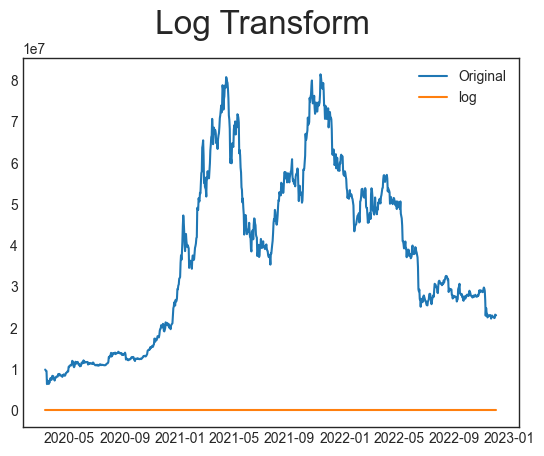

In [39]:
import numpy as np
log_bitcoin_data_train = bitcoin_data_train.copy()
log_bitcoin_data_train =np.log(bitcoin_df) #로그변환
plt.plot(bitcoin_df, label='Original')
plt.plot(log_bitcoin_data_train,label='log')
plt.suptitle("Log Transform", size= 24)
plt.legend()
plt.show()

In [40]:
diff_bitcoin_data_train = log_bitcoin_data_train.copy() #차분
diff_bitcoin_data_train = diff_bitcoin_data_train.diff()
diff_bitcoin_data_train = diff_bitcoin_data_train.dropna() #결측치 제거
print('##### Raw Data #####')
print(bitcoin_data_train)
print('##### Differenced Data #####')
print(diff_bitcoin_data_train)

##### Raw Data #####
                          close
2020-03-08 09:00:00   9876000.0
2020-03-09 09:00:00   9726000.0
2020-03-10 09:00:00   9574000.0
2020-03-11 09:00:00   9510000.0
2020-03-12 09:00:00   6363000.0
...                         ...
2022-05-12 09:00:00  39243000.0
2022-05-13 09:00:00  39270000.0
2022-05-14 09:00:00  39967000.0
2022-05-15 09:00:00  40906000.0
2022-05-16 09:00:00  39256000.0

[800 rows x 1 columns]
##### Differenced Data #####
                        close
2020-03-09 09:00:00 -0.015305
2020-03-10 09:00:00 -0.015752
2020-03-11 09:00:00 -0.006707
2020-03-12 09:00:00 -0.401844
2020-03-13 09:00:00  0.132844
...                       ...
2022-11-28 09:00:00 -0.013649
2022-11-29 09:00:00  0.003486
2022-11-30 09:00:00  0.033988
2022-12-01 09:00:00 -0.008226
2022-12-02 09:00:00  0.000348

[999 rows x 1 columns]


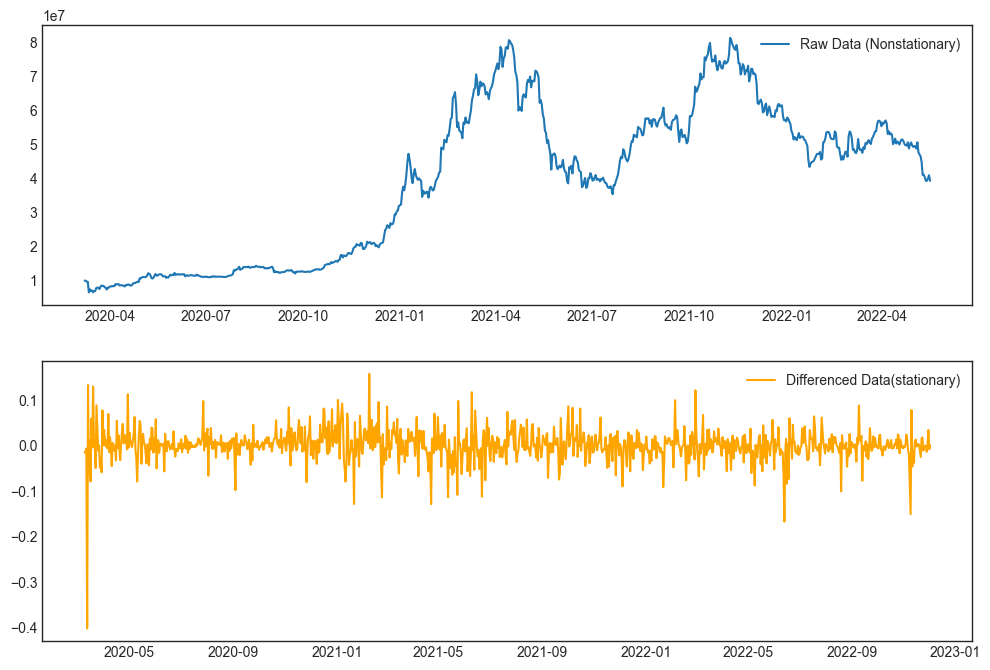

In [41]:
# Differenced data plot

plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(bitcoin_data_train['close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_bitcoin_data_train, 'orange') #첫번째 차분 (t- (t-1))
plt.legend(['Differenced Data(stationary)'])
plt.show()

c:\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


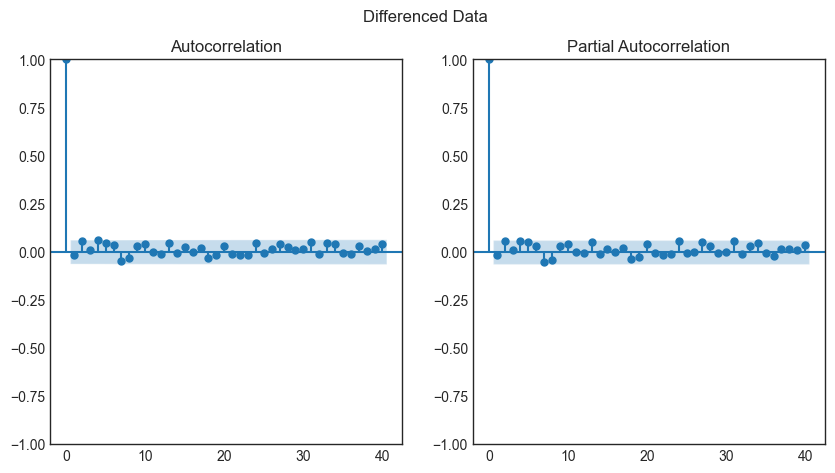

In [42]:
fig, ax= plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_bitcoin_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_bitcoin_data_train.values.squeeze(), lags=40, ax=ax[1]);

In [43]:
import matplotlib.pyplot as plt #adf테스트를 먼저해서 정상인지 확인
from statsmodels.tsa.stattools import adfuller

def ADF(bitcoin_df): #ADF검정 
    result = adfuller(bitcoin_df, autolag="AIC")
    
    print('---- Adfuller ----')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' %result[3])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
ADF(diff_bitcoin_data_train)

---- Adfuller ----
ADF Statistic: -12.752385
p-value: 0.0000000000
Lag: 4
observation: 994
Critical values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [44]:
#파라미터 Search

auto_arima_model = auto_arima(bitcoin_data_train, start_p=1, start_q=1,
                             max_p=3, max_q=3,seasona=False,
                             d=1,
                             trace= True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=25003.381, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=25001.664, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=25003.249, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=25001.423, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=25001.816, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=25001.071, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=25005.733, Time=0.58 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=25001.185, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=25003.545, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=25003.060, Time=0.61 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=25003.084, Time=1.12 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=25002.027, Time=1.88 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=25001.501, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=25002.040, Time=0.94 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=25003.263, Time=1.22

In [45]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  800
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -12496.535
Date:                Fri, 02 Dec 2022   AIC                          25001.071
Time:                        09:26:56   BIC                          25019.804
Sample:                    03-08-2020   HQIC                         25008.268
                         - 05-16-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.554e+04   9.23e+04      0.385      0.700   -1.45e+05    2.16e+05
ar.L1         -0.6396      0.195     -3.285      0.001      -1.021      -0.258
ma.L1          0.7070      0.177      3.992      0.000       0.360       1.054
sigma2      2.254e+12      0.004   6.12e+14      0.000    2.25e+12    2.25e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               763.85
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):              18.30   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.03e+30. Standard errors may be unstable.
"""

In [46]:
print(bitcoin_data_train)
print(bitcoin_data_test)

                          close
2020-03-08 09:00:00   9876000.0
2020-03-09 09:00:00   9726000.0
2020-03-10 09:00:00   9574000.0
2020-03-11 09:00:00   9510000.0
2020-03-12 09:00:00   6363000.0
...                         ...
2022-05-12 09:00:00  39243000.0
2022-05-13 09:00:00  39270000.0
2022-05-14 09:00:00  39967000.0
2022-05-15 09:00:00  40906000.0
2022-05-16 09:00:00  39256000.0

[800 rows x 1 columns]
                          close
2022-05-17 09:00:00  39259000.0
2022-05-18 09:00:00  37099000.0
2022-05-19 09:00:00  38780000.0
2022-05-20 09:00:00  37762000.0
2022-05-21 09:00:00  38037000.0
...                         ...
2022-11-28 09:00:00  22339000.0
2022-11-29 09:00:00  22417000.0
2022-11-30 09:00:00  23192000.0
2022-12-01 09:00:00  23002000.0
2022-12-02 09:00:00  23010000.0

[200 rows x 1 columns]


In [47]:
prediction = auto_arima_model.predict(len(bitcoin_data_test),return_conf_int = True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(bitcoin_data_test.index)
predict_index[0]

Timestamp('2022-05-17 09:00:00')

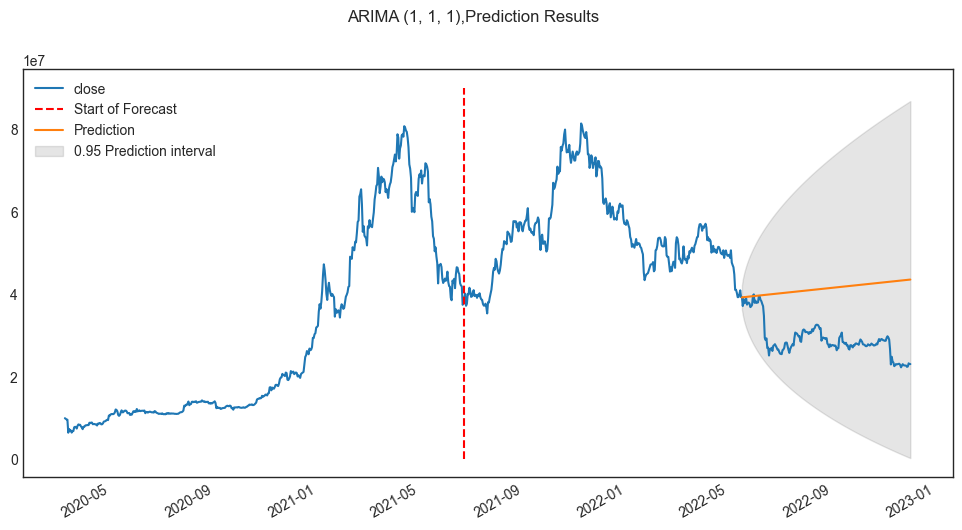

In [48]:
fig, ax = plt.subplots(figsize= (12, 6))
bitcoin_df.plot(ax=ax);
ax.vlines('2021-06-23',0,90000000.0, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order},Prediction Results')
plt.show()

정확하게 잡아내기는 어려웠지만 제공하는 프레딕션 인터벌 안에 실제 테스트 셋이 포함되어 있는 것을 알 수 있었습니다.                                                                                                                                          

2022/05/26
- 2022년 1월부터로 트레이닝 시켜보기 /in[16]확인해보기
- 환율같은 거 넣고 해보기 